# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Datawrangling

# Datawrangling portfolio

In [190]:
portfolio.head(2)

channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   

                                 id offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd       bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0       bogo      10

In [191]:
portfolio.isnull().sum().sum()

0

In [192]:
portfolio.shape

(10, 6)

In [193]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [194]:
#As mentioned in the description, id=offer id, hence rename id to offer id
portfolio = portfolio.rename(columns={'id':'offer_id'})
portfolio.head()

channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   

                           offer_id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5

# Datawrangling profile

In [195]:
profile.head(2)

age  became_member_on gender                                id    income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783       NaN
1   55          20170715      F  0610b486422d4921ae7d2bf64640c50b  112000.0

In [196]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [197]:
profile['gender'].fillna((profile['gender'].mode()[0]), inplace=True)
profile['income'].fillna((profile['income'].mean()), inplace=True)
profile = profile.rename(columns={'id':'customer_id'})
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [198]:
profile.head(2)

age became_member_on gender                       customer_id  \
0  118       2017-02-12      M  68be06ca386d4c31939f3a4f0e3dd783   
1   55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b   

          income  
0   65404.991568  
1  112000.000000

# Datawrangling Transcript

In [199]:
transcript.head(2)

event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   

                                              value  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}

In [206]:
transcript.isnull().sum().sum()

306534

In [207]:
#https://stackoverflow.com/questions/60106364/

transcript['offer_id'] = [[*x.values()][0]if [*x.keys()][0] in ['offer id','offer_id'] else None for x in transcript.value]
transcript['amount'] = [[*x.values()][0]if [*x.keys()][0] == 'amount' else None for x in transcript.value]

AttributeError: 'DataFrame' object has no attribute 'value'

In [208]:
transcript.head(2)

event                       customer_id  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   

                           offer_id  amount  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN

In [209]:
transcript=transcript.drop(columns='value')
transcript=transcript.rename(columns={'person':'customer_id'})
transcript.head()

KeyError: "['value'] not found in axis"

In [210]:
transcript.isnull().sum()

event               0
customer_id         0
time                0
offer_id       138953
amount         167581
dtype: int64

In [211]:
transcript.describe()

time         amount
count  306534.000000  138953.000000
mean      366.382940      12.777356
std       200.326314      30.250529
min         0.000000       0.050000
25%       186.000000       2.780000
50%       408.000000       8.890000
75%       528.000000      18.070000
max       714.000000    1062.280000

# get Rid of Outlier

In [212]:
profile = profile.drop(profile[(profile.age > 100)].index)

# Onehot encoding

# Onehot encoding Portfolio

In [213]:
#Code source Udacity Mentor ,https://knowledge.udacity.com/questions/567811
#Creating dummy variable for channel
mlb = MultiLabelBinarizer()
channel_d = pd.DataFrame(mlb.fit_transform(portfolio['channels']), columns=mlb.classes_, index=portfolio.index)
channel_d.head(1)

email  mobile  social  web
0      1       1       1    0

In [214]:
#creating dummy variable for offer
offer_d=pd.get_dummies(portfolio.offer_type)
offer_d.head(1)

bogo  discount  informational
0     1         0              0

In [215]:
#Concatinate Channel and offer dummies with portfolio
portfolio = pd.concat([portfolio, channel_d, offer_d], axis=1)
portfolio.head(1)

channels  difficulty  duration  \
0  [email, mobile, social]          10         7   

                           offer_id offer_type  reward  email  mobile  social  \
0  ae264e3637204a6fb9bb56bc8210ddfd       bogo      10      1       1       1   

   web  bogo  discount  informational  
0    0     1         0              0

In [216]:
portfolio.columns.duplicated().sum()

0

# Onehotencoding profile

In [217]:
gender_d=pd.get_dummies(profile.gender)
gender_d.head(1)

F  M  O
1  1  0  0

In [218]:
#One Hot encoding of "became_member_on" column of Profile dataset. Here I want to extrat Year and create columns for just 
#those years. 
profile['year'] = pd.DatetimeIndex(profile['became_member_on']).year
profile.head(1)

age became_member_on gender                       customer_id    income  \
1   55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0   

   year  
1  2017

In [219]:
year_d=pd.get_dummies(profile.year)
year_d.head(1)

2013  2014  2015  2016  2017  2018
1     0     0     0     0     1     0

In [220]:
profile = pd.concat([profile, gender_d, year_d], axis=1)
profile=profile.rename(columns={'id':'customer_id'})

profile.head(1)

age became_member_on gender                       customer_id    income  \
1   55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0   

   year  F  M  O  2013  2014  2015  2016  2017  2018  
1  2017  1  0  0     0     0     0     0     1     0

In [221]:
profile.columns.duplicated().sum()

0

In [222]:
#There is a repeatation of years, we need to drop that
profile= profile.loc[:,~profile.columns.duplicated()]
profile=profile.drop(['became_member_on','year'],axis=1)
profile.head(1)

age gender                       customer_id    income  F  M  O  2013  \
1   55      F  0610b486422d4921ae7d2bf64640c50b  112000.0  1  0  0     0   

   2014  2015  2016  2017  2018  
1     0     0     0     1     0

# Onehot encoding of Transcript

In [223]:
event_d=pd.get_dummies(transcript.event)
event_d.head(2)

offer completed  offer received  offer viewed  transaction
0                0               1             0            0
1                0               1             0            0

In [224]:
transcript = pd.concat([transcript, event_d], axis=1)
transcript.head(1)

event                       customer_id  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   

                           offer_id  amount  offer completed  offer received  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN                0               1   

   offer viewed  transaction  
0             0            0

In [225]:
transcript.columns.duplicated().sum()

0

In [226]:
transcript= transcript.loc[:,~transcript.columns.duplicated()]

# Merge encoded Dataframes

In [227]:
df1= pd.merge(transcript, profile, on='customer_id')
df1.head(1)

event                       customer_id  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   

                           offer_id  amount  offer completed  offer received  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN                0               1   

   offer viewed  transaction  age gender    income  F  M  O  2013  2014  2015  \
0             0            0   75      F  100000.0  1  0  0     0     0     0   

   2016  2017  2018  
0     0     1     0

In [228]:
df2 = pd.merge(df1,portfolio, on='offer_id', how='left')
pd.set_option('display.max_columns',None)
df2.head(1)

event                       customer_id  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   

                           offer_id  amount  offer completed  offer received  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN                0               1   

   offer viewed  transaction  age gender    income  F  M  O  2013  2014  2015  \
0             0            0   75      F  100000.0  1  0  0     0     0     0   

   2016  2017  2018              channels  difficulty  duration offer_type  \
0     0     1     0  [web, email, mobile]         5.0       7.0       bogo   

   reward  email  mobile  social  web  bogo  discount  informational  
0     5.0    1.0     1.0     0.0  1.0   1.0       0.0            0.0

# Create two seperate dataframe Offer and Transaction dataframe

In [229]:
df3=df2.query('event=="transaction"')
df3.head(4)

event                       customer_id  time offer_id  amount  \
2  transaction  78afa995795e4d85b5d9ceeca43f5fef   132     None   19.89   
4  transaction  78afa995795e4d85b5d9ceeca43f5fef   144     None   17.78   
7  transaction  78afa995795e4d85b5d9ceeca43f5fef   222     None   19.67   
8  transaction  78afa995795e4d85b5d9ceeca43f5fef   240     None   29.72   

   offer completed  offer received  offer viewed  transaction  age gender  \
2                0               0             0            1   75      F   
4                0               0             0            1   75      F   
7                0               0             0            1   75      F   
8                0               0             0            1   75      F   

     income  F  M  O  2013  2014  2015  2016  2017  2018 channels  difficulty  \
2  100000.0  1  0  0     0     0     0     0     1     0      NaN         NaN   
4  100000.0  1  0  0     0     0     0     0     1     0      NaN         NaN   
7  100000.0  1  0  0     0     0     0     0     1     0      NaN         NaN   
8  100000.0  1  0  0     0     0     0     0     1     0      NaN         NaN   

   duration offer_type  reward  email  mobile  social  web  bogo  discount  \
2       NaN        NaN     NaN    NaN     NaN     NaN  NaN   NaN       NaN   
4       NaN        NaN     NaN    NaN     NaN     NaN  NaN   NaN       NaN   
7       NaN        NaN     NaN    NaN     NaN     NaN  NaN   NaN       NaN   
8       NaN        NaN     NaN    NaN     NaN     NaN  NaN   NaN       NaN   

   informational  
2            NaN  
4            NaN  
7            NaN  
8            NaN

In [230]:
df3.update(df3[['channels','difficulty','duration','offer_type','reward','email','mobile','social','web','bogo','discount','informational']].fillna(0))


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:5085: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


In [231]:
df3.head(2)

event                       customer_id  time offer_id  amount  \
2  transaction  78afa995795e4d85b5d9ceeca43f5fef   132     None   19.89   
4  transaction  78afa995795e4d85b5d9ceeca43f5fef   144     None   17.78   

   offer completed  offer received  offer viewed  transaction  age gender  \
2                0               0             0            1   75      F   
4                0               0             0            1   75      F   

     income  F  M  O  2013  2014  2015  2016  2017  2018 channels  difficulty  \
2  100000.0  1  0  0     0     0     0     0     1     0        0         0.0   
4  100000.0  1  0  0     0     0     0     0     1     0        0         0.0   

   duration offer_type  reward  email  mobile  social  web  bogo  discount  \
2       0.0          0     0.0    0.0     0.0     0.0  0.0   0.0       0.0   
4       0.0          0     0.0    0.0     0.0     0.0  0.0   0.0       0.0   

   informational  
2            0.0  
4            0.0

In [232]:
df4=df2.query('event !="transaction"')
df4['channels'] = df4['channels'].apply(lambda x : ','.join(x))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [233]:
df4.duplicated().sum()

374

In [234]:
df4=df4.drop_duplicates(subset=None, keep='first', inplace=False)

In [235]:
df4.head(2)
df4.update(df4[['amount']].fillna(0))

df4.head()

event                       customer_id  time  \
0   offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1     offer viewed  78afa995795e4d85b5d9ceeca43f5fef     6   
3  offer completed  78afa995795e4d85b5d9ceeca43f5fef   132   
5   offer received  78afa995795e4d85b5d9ceeca43f5fef   168   
6     offer viewed  78afa995795e4d85b5d9ceeca43f5fef   216   

                           offer_id  amount  offer completed  offer received  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     0.0                0               1   
1  9b98b8c7a33c4b65b9aebfe6a799e6d9     0.0                0               0   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9     0.0                1               0   
5  5a8bc65990b245e5a138643cd4eb9837     0.0                0               1   
6  5a8bc65990b245e5a138643cd4eb9837     0.0                0               0   

   offer viewed  transaction  age gender    income  F  M  O  2013  2014  2015  \
0             0            0   75      F  100000.0  1  0  0     0     0     0   
1             1            0   75      F  100000.0  1  0  0     0     0     0   
3             0            0   75      F  100000.0  1  0  0     0     0     0   
5             0            0   75      F  100000.0  1  0  0     0     0     0   
6             1            0   75      F  100000.0  1  0  0     0     0     0   

   2016  2017  2018             channels  difficulty  duration     offer_type  \
0     0     1     0     web,email,mobile         5.0       7.0           bogo   
1     0     1     0     web,email,mobile         5.0       7.0           bogo   
3     0     1     0     web,email,mobile         5.0       7.0           bogo   
5     0     1     0  email,mobile,social         0.0       3.0  informational   
6     0     1     0  email,mobile,social         0.0       3.0  informational   

   reward  email  mobile  social  web  bogo  discount  informational  
0     5.0    1.0     1.0     0.0  1.0   1.0       0.0            0.0  
1     5.0    1.0     1.0     0.0  1.0   1.0       0.0            0.0  
3     5.0    1.0     1.0     0.0  1.0   1.0       0.0            0.0  
5     0.0    1.0     1.0     1.0  0.0   0.0       0.0            1.0  
6     0.0    1.0     1.0     1.0  0.0   0.0       0.0            1.0

In [236]:
df5=df4[['customer_id','age','income','gender']]
df5.duplicated().sum()
df5=df5.drop_duplicates(subset=None, keep='first', inplace=False)

# Data Exploration

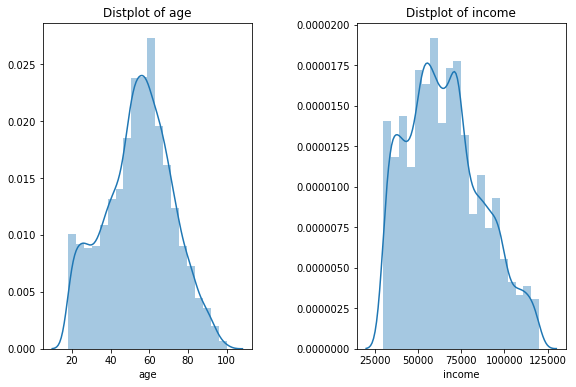

In [237]:

plt.figure(1,figsize=(15,6))
n=0
for x in['age','income']:
    n+=1
    plt.subplot(1,3,n)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    sns.distplot(df5[x],bins=20)
    plt.title('Distplot of {}'.format(x))
plt.show()

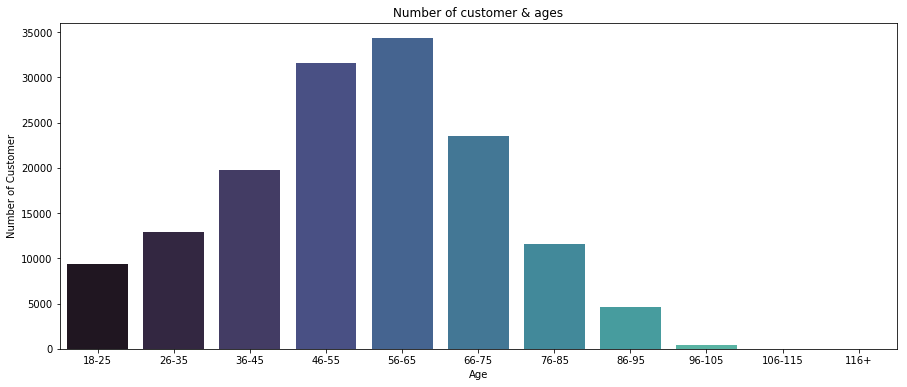

In [238]:
age_18_25 = df4.age[(df4.age>=18) & (df4.age<=25)]
age_26_35 = df4.age[(df4.age>=26) & (df4.age<=35)]
age_36_45 = df4.age[(df4.age>=36) & (df4.age<=45)]
age_46_55 = df4.age[(df4.age>=46) & (df4.age<=55)]
age_56_65 = df4.age[(df4.age>=56) & (df4.age<=65)]
age_66_75 = df4.age[(df4.age>=66) & (df4.age<=75)]
age_76_85 = df4.age[(df4.age>=76) & (df4.age<=85)]
age_86_95 = df4.age[(df4.age>=86) & (df4.age<=95)]
age_96_105  = df4.age[(df4.age>=96) & (df4.age<=105)]
age_106_115  = df4.age[(df4.age>=106) & (df4.age<=115)]
age_116above  = df4.age[df4.age>=116]
agex=["18-25","26-35","36-45","46-55","56-65","66-75","76-85","86-95","96-105","106-115","116+"]
agey=[len(age_18_25.values),len(age_26_35.values),len(age_36_45.values),len(age_46_55.values),len(age_56_65.values),
      len(age_66_75.values),len(age_76_85.values),len(age_86_95.values),len(age_96_105.values),len(age_106_115.values),
      len(age_116above.values)]

plt.figure(figsize=(15,6))
sns.barplot(x=agex,y=agey,palette="mako")
plt.title("Number of customer & ages")
plt.xlabel("Age")
plt.ylabel("Number of Customer")
plt.show()

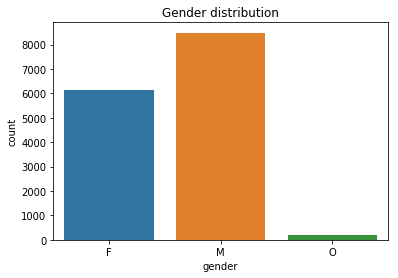

In [239]:
ax = sns.countplot(x='gender', data=df5)
ax.set_title('Gender distribution');

[Text(0,0.5,'Count'), Text(0.5,0,''), Text(0.5,1,'Informational')]

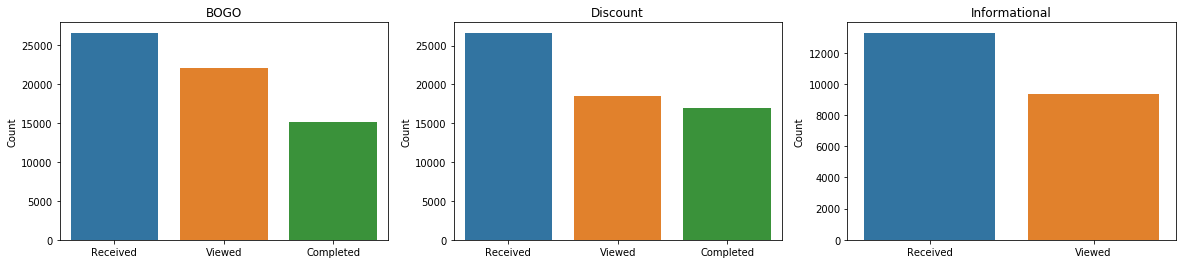

In [240]:
df = df4.groupby(['event', 'offer_type'])['customer_id'].count().reset_index()
df['event'] = pd.Categorical(df['event'], ["offer received", "offer viewed", "offer completed"])
df.sort_values('event', inplace=True)

fig, axs = plt.subplots(ncols=3, figsize=(20, 4))

df['event'] = df['event'].map({'offer received': 'Received', 'offer viewed': 'Viewed', 'offer completed': 'Completed'})

ax = sns.barplot('event', y='customer_id', data=df.query('offer_type == "bogo"'),  ax=axs[0])
ax.set(xlabel='', ylabel='Count', title='BOGO')

ax = sns.barplot('event', y='customer_id', data=df.query('offer_type == "discount"'), ci=None, ax=axs[1])
ax.set(xlabel='', ylabel='Count', title='Discount')

ax = sns.barplot('event', y='customer_id', data=df.query('offer_type == "informational"'), ci=None, ax=axs[2])
ax.set(xlabel='', ylabel='Count', title='Informational')



In [241]:
offer_received = df4[df4['offer received'] == 1].offer_type.value_counts().sum()
Offer_viewed = df4[df4['offer viewed'] == 1].offer_type.value_counts().sum()
Offer_completed = df4[df4['offer completed'] == 1].offer_type.value_counts().sum()

offer_received=df4.groupby('bogo')['offer received'].value_counts()
offer_viewed=df4.groupby('bogo')['offer viewed'].value_counts()
offer_completed=df4.groupby('bogo')['offer completed'].value_counts()

eff_bogo1=offer_viewed/offer_received*100
eff_bogo2=offer_completed/offer_viewed*100

eff_bogo1;eff_bogo2


bogo  offer completed
0.0   0                  119.062264
      1                   60.991837
1.0   0                  116.667067
      1                   68.512048
dtype: float64

In [242]:
offer_received=df4.groupby('discount')['offer received'].value_counts()
offer_viewed=df4.groupby('discount')['offer viewed'].value_counts()
offer_completed=df4.groupby('discount')['offer completed'].value_counts()

eff_discount1=offer_viewed/offer_received*100
eff_discount2=offer_completed/offer_viewed*100

eff_discount1;eff_discount2


discount  offer completed
0.0       0                  129.665368
          1                   48.095056
1.0       0                  103.421234
          1                   91.914156
dtype: float64

In [243]:
df_t=df2[['customer_id','amount','age','gender']]
df_agg = df_t.groupby(['age',]).agg({'amount':sum})
pd.set_option('display.max_rows',None)
df_agg=df_agg.sort_values(by=['amount'],ascending=False)
df_agg

amount
age          
58   56201.03
53   50985.19
55   49928.62
57   48138.62
59   43947.55
54   43417.10
67   42483.99
51   42257.66
63   41243.36
62   41142.34
60   40548.71
56   40542.10
52   40287.18
64   39867.97
65   37843.28
61   37665.54
50   36555.16
49   36175.86
66   34884.60
68   33330.20
48   33091.18
69   29689.24
71   29335.83
70   28177.30
73   26720.40
74   25896.04
39   23116.30
37   23085.48
42   22937.27
45   22820.91
46   22785.74
72   22648.40
43   22522.10
44   22458.15
41   21947.26
47   21914.62
75   21424.78
40   20782.11
38   20618.24
77   18725.27
76   18150.10
78   17089.23
81   17076.85
36   16143.91
80   15850.12
82   15022.53
79   14667.26
83   14240.05
21   13838.49
32   13691.47
35   12779.55
26   12718.04
30   12645.01
34   12483.42
22   12337.02
84   12257.63
28   12161.00
25   11936.84
33   11796.55
24   11760.80
29   11758.43
20   10379.90
27   10273.13
23    9818.48
19    9705.12
88    8986.66
85    8081.45
31    8007.03
87    7616.99
89    6720.78
86    6476.13
90    6214.40
18    5632.57
92    5479.62
91    5143.31
94    4823.06
93    3350.43
95    2422.67
97    2119.94
100   2032.74
96    1020.82
99     841.88
98     370.38

In [244]:
#df_t=df2[['customer_id','amount','age','gender']]
#df_agg = df_t.groupby(['customer_id',]).agg({'amount':sum})
#df_agg.reset_index(inplace=True)
#df_agg = df_agg.merge(df_t[['customer_id','age','gender']],on='customer_id',how="left")
#df_agg=df_agg.drop_duplicates(subset=None, keep='first', inplace=False)
#df_agg=df_agg.sort_values(by=['amount'],ascending=False)
#df_agg

# KMeans

In [245]:
df5=df4.drop_duplicates(subset=None, keep='first', inplace=False)
df5 = df5.drop(df4[(df4.age > 100)].index)
df5 = df5.drop('offer_type',axis=1)
df5 = df5.drop('amount',axis=1)
df5 = df5.drop('channels',axis=1)
df5 = df5.drop('gender',axis=1)
df5 = df5.drop('event',axis=1)
df5 = df5.drop('offer_id',axis=1)
df5=df5.drop('time',axis=1)
df5=df5.drop('customer_id',axis=1)
df5.head(4)


offer completed  offer received  offer viewed  transaction  age    income  \
0                0               1             0            0   75  100000.0   
1                0               0             1            0   75  100000.0   
3                1               0             0            0   75  100000.0   
5                0               1             0            0   75  100000.0   

   F  M  O  2013  2014  2015  2016  2017  2018  difficulty  duration  reward  \
0  1  0  0     0     0     0     0     1     0         5.0       7.0     5.0   
1  1  0  0     0     0     0     0     1     0         5.0       7.0     5.0   
3  1  0  0     0     0     0     0     1     0         5.0       7.0     5.0   
5  1  0  0     0     0     0     0     1     0         0.0       3.0     0.0   

   email  mobile  social  web  bogo  discount  informational  
0    1.0     1.0     0.0  1.0   1.0       0.0            0.0  
1    1.0     1.0     0.0  1.0   1.0       0.0            0.0  
3    1.0     1.0     0.0  1.0   1.0       0.0            0.0  
5    1.0     1.0     1.0  0.0   0.0       0.0            1.0

In [246]:
df3.head(2)

event                       customer_id  time offer_id  amount  \
2  transaction  78afa995795e4d85b5d9ceeca43f5fef   132     None   19.89   
4  transaction  78afa995795e4d85b5d9ceeca43f5fef   144     None   17.78   

   offer completed  offer received  offer viewed  transaction  age gender  \
2                0               0             0            1   75      F   
4                0               0             0            1   75      F   

     income  F  M  O  2013  2014  2015  2016  2017  2018 channels  difficulty  \
2  100000.0  1  0  0     0     0     0     0     1     0        0         0.0   
4  100000.0  1  0  0     0     0     0     0     1     0        0         0.0   

   duration offer_type  reward  email  mobile  social  web  bogo  discount  \
2       0.0          0     0.0    0.0     0.0     0.0  0.0   0.0       0.0   
4       0.0          0     0.0    0.0     0.0     0.0  0.0   0.0       0.0   

   informational  
2            0.0  
4            0.0

In [247]:
df3=df3[['customer_id','age','gender','income','amount']]
df3.head()

customer_id  age gender    income  amount
2  78afa995795e4d85b5d9ceeca43f5fef   75      F  100000.0   19.89
4  78afa995795e4d85b5d9ceeca43f5fef   75      F  100000.0   17.78
7  78afa995795e4d85b5d9ceeca43f5fef   75      F  100000.0   19.67
8  78afa995795e4d85b5d9ceeca43f5fef   75      F  100000.0   29.72
9  78afa995795e4d85b5d9ceeca43f5fef   75      F  100000.0   23.93

In [248]:
df_agg = df3.groupby(['customer_id',]).agg({'amount':sum})
df_agg.reset_index(inplace=True)
df_agg = df_agg.merge(df3[['customer_id','age','gender','income']],on='customer_id',how="left")
df_agg=df_agg.drop_duplicates(subset=None, keep='first', inplace=False)
df_agg=df_agg.sort_values(by=['amount'],ascending=False)
df_agg

customer_id   amount  age gender    income
29383   3c8d541112a74af99e88abbd0692f00e  1608.69   77      M   97000.0
117108  f1d65ae63f174b8f80fa063adcaa63b7  1365.66   32      M   64000.0
84702   ae6f43089b674728a50b8727252d3305  1327.74   36      F   71000.0
47327   626df8678e2a4953b9098246418c9cfa  1321.42   53      M  103000.0
55434   73afdeca19e349b98f09e928644610f8  1319.97   50      M   86000.0
40027   52959f19113e4241a8cb3bef486c6412  1292.86   55      M  111000.0
84027   ad1f0a409ae642bc9a43f31f56c130fc  1258.19   66      M   80000.0
101675  d240308de0ee4cf8bb6072816268582b  1251.99   43      F   94000.0
71664   946fc0d3ecc4492aa4cc06cf6b1492c3  1232.40   58      M   79000.0
48143   6406abad8e2c4b8584e4f68003de148d  1211.76   67      M   79000.0
52288   6cf884a6c5ae4b2daccb6d3108028fef  1165.26   58      F  110000.0
67666   8c6b2a81cb294c28b740e9c459ab7767  1154.75   58      F   97000.0
45700   5ecaea5c8bf44ae4a65838d9d066c909  1153.11   55      F   97000.0
37418   4d0ebb94a5a94fe6afd9350c7b1477e4  1152.94   81      M  117000.0
106770  dce784e26f294101999d000fad9089bb  1151.86   53      F  110000.0
2776    05bedc6bbcc64a41b1745f6efe00776d  1148.92   70      F  105000.0
81129   a73cf044395d46ea804f688490ad9227  1128.22   60      M  106000.0
97745   ca715b3f17e24692b18f3cd90b9bf232  1118.78   59      M   86000.0
96393   c7a5d7bab83a4d82a7f977b3d586f3d4  1118.73   48      F   91000.0
45319   5dfdad4241764dfe959f51b7460e42b1  1112.66   47      F   97000.0
60303   7d7f271652d244f78b97c73cd734c553  1106.17   37      M   98000.0
13369   1c05e4a68fc04d3da27454cb7eaa6144  1099.28   90      F  104000.0
33633   454b00bdd77c4f588eb9f6cafd81dc5d  1087.98   53      F   89000.0
112487  e7f53eb7aba343e09c8975e998cdf0a6  1087.24   58      M   86000.0
4924    0a3c4a0c066d49f1ad4eb52987a0fb05  1084.84   64      M   98000.0
97685   ca3ed3e47a1e4ceea8dcd8b2bbaf1076  1080.21   63      F   87000.0
118551  f4e953ec3a484683935d8d42216fd11e  1080.07   71      M   95000.0
93419   c0bbc13872474c63a83e8b503bb88f72  1075.80   58      F   85000.0
89943   b923ef146c9d48518edc006f611f0f5c  1074.65   58      M   96000.0
99069   cd10ba15be244a36a61dc4256e7d6f6b  1069.53   72      F   94000.0
16971   23dfcdb8237347dca870bf78d7fa823c  1058.24   67      F   86000.0
115821  ef65dd061ff24b0f805a51dd0328dbcb  1054.06   80      M   89000.0
16399   22a945be84664ab59b5bff02429bf462  1040.98   21      M   45000.0
110200  e37a0ba3db6544caad344622b4f82670  1039.62   62      F   85000.0
29314   3c7108e2cf594134ac0bb027e040afb5  1039.27   60      F   99000.0
121259  fa38365493e34ddead796e2a183bd8b5  1039.09   65      F   88000.0
8099    10f7af1a6eb943e58c133d1043866c35  1036.68   67      M   84000.0
76681   9e523a3e05e14fd0bfec8ac108ce2cab  1035.01   71      F  107000.0
107875  df1e6d50effb4af28aff99f69fd3f394  1031.88   57      F  102000.0
47736   633815975da245bb83537702f1ffa118  1031.71   59      M   79000.0
2802    05c64ce569db467a939173b41889a77a  1030.60   80      F  116000.0
35626   490ca12f690d413aaf75d08c56067ea4  1027.14   58      F  111000.0
118545  f4e2258e9c23436e8db7dea8a2e12ec5  1016.93   55      F   81000.0
78157   a12fba072dae4e3aae2e1b4b92b92aa1  1011.82   55      F   97000.0
118313  f47051cad4844338be9332c33ddba9ef  1010.78   88      M  111000.0
19574   29655cba61a04d079efde18203b4f232  1004.98   67      F  101000.0
649     017febbe52e64ac19cf28cf0d44386e4  1003.41   61      M  100000.0
93723   c18566c8d89149a3b87f828a6e22b47b  1000.57   53      F   84000.0
5183    0abb3f3cf3634fd4866a22052f8c9e5f   998.59   57      M   97000.0
17997   25c258df0487470c8d1cfed9feca14cd   996.96   61      F  119000.0
99511   ce235b5491eb4a21857a5de3355a310b   996.53   94      M  101000.0
14584   1eab10bfe6e84352813a29ef0001f2f2   990.08   68      M   93000.0
108469  e0570660882b49db860b43f704e5590b   987.54   38      F   72000.0
82683   aad657e5b55b4332a3a12a99034dbb0c   984.69   24      F   75000.0
118586  f4fa477e66204420b0c0b90448596a46   981.37   84      F  106000

In [249]:
df_agg.dtypes

customer_id     object
amount         float64
age              int64
gender          object
income         float64
dtype: object

In [250]:
df.isnull().sum().sum()

0

In [251]:
df_agg.drop(["customer_id"],axis=1)

amount  age gender    income
29383   1608.69   77      M   97000.0
117108  1365.66   32      M   64000.0
84702   1327.74   36      F   71000.0
47327   1321.42   53      M  103000.0
55434   1319.97   50      M   86000.0
40027   1292.86   55      M  111000.0
84027   1258.19   66      M   80000.0
101675  1251.99   43      F   94000.0
71664   1232.40   58      M   79000.0
48143   1211.76   67      M   79000.0
52288   1165.26   58      F  110000.0
67666   1154.75   58      F   97000.0
45700   1153.11   55      F   97000.0
37418   1152.94   81      M  117000.0
106770  1151.86   53      F  110000.0
2776    1148.92   70      F  105000.0
81129   1128.22   60      M  106000.0
97745   1118.78   59      M   86000.0
96393   1118.73   48      F   91000.0
45319   1112.66   47      F   97000.0
60303   1106.17   37      M   98000.0
13369   1099.28   90      F  104000.0
33633   1087.98   53      F   89000.0
112487  1087.24   58      M   86000.0
4924    1084.84   64      M   98000.0
97685   1080.21   63      F   87000.0
118551  1080.07   71      M   95000.0
93419   1075.80   58      F   85000.0
89943   1074.65   58      M   96000.0
99069   1069.53   72      F   94000.0
16971   1058.24   67      F   86000.0
115821  1054.06   80      M   89000.0
16399   1040.98   21      M   45000.0
110200  1039.62   62      F   85000.0
29314   1039.27   60      F   99000.0
121259  1039.09   65      F   88000.0
8099    1036.68   67      M   84000.0
76681   1035.01   71      F  107000.0
107875  1031.88   57      F  102000.0
47736   1031.71   59      M   79000.0
2802    1030.60   80      F  116000.0
35626   1027.14   58      F  111000.0
118545  1016.93   55      F   81000.0
78157   1011.82   55      F   97000.0
118313  1010.78   88      M  111000.0
19574   1004.98   67      F  101000.0
649     1003.41   61      M  100000.0
93723   1000.57   53      F   84000.0
5183     998.59   57      M   97000.0
17997    996.96   61      F  119000.0
99511    996.53   94      M  101000.0
14584    990.08   68      M   93000.0
108469   987.54   38      F   72000.0
82683    984.69   24      F   75000.0
118586   981.37   84      F  106000.0
40608    980.61   61      M   98000.0
36393    977.76   97      M   85000.0
54209    977.70   41      F   83000.0
123478   973.74   55      M  100000.0
21215    971.24   65      F   83000.0
99628    966.86   67      F   71000.0
86037    960.21   68      F   76000.0
42594    958.47   53      M  111000.0
97621    958.19   83      M   70000.0
55394    954.30   56      F   98000.0
74858    953.39   21      M   39000.0
107460   952.11   42      F  100000.0
13886    952.02   65      F   87000.0
31980    951.53   79      M  113000.0
22773    946.98   69      F   73000.0
75841    945.25   74      F   84000.0
63064    945.09   66      F  108000.0
94033    932.22   37      M   87000.0
17930    931.81   75      M   92000.0
44927    928.64   21      M   74000.0
40964    927.42   64      M   95000.0
113083   926.87   60      M   88000.0
21482    922.05   56      F   82000.0
107552   917.59   52      M  105000.0
45614    916.12   39      M   91000.0
54998    908.81   64      F   73000.0
106480   904.79   78      M   95000.0
6154     903.93   74      F  117000.0
58431    902.94   64      F  106000.0
119623   897.77   62      M  113000.0
54720    893.33   53      F   72000.0
31550    892.02   81      M   72000.0
17913    882.37   30      F   69000.0
31643    874.63   44      M   75000.0
99827    873.89   54      F   86000.0
83922    869.02   72      F   91000.0
92660    868.51   62      F   85000.0
11209    863.24   38      M   90000.0
107897   862.51   71      M   81000.0
5090     861.33   56      M  107000.0
100854   857.75   60      O   94000.0
44485    848.19   37      F   72000.0
34662    847.52   18      M   61000.0
118409   844.38   54      M   70000.0
75467    844.30   60      M   77000.0
68081    840.92   92      F  105000.0
39829    835.83   65      F   89000.0
18023    835.05   37      F   54000.0
24956    832.78   80      F  118000.0
101230   832.22   4

In [252]:
df_agg.isnull().sum().sum()

0

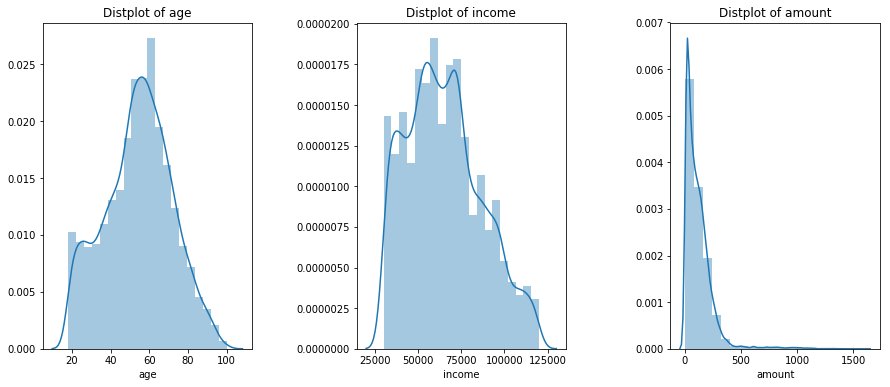

In [253]:
plt.figure(1,figsize=(15,6))
n=0
for x in ['age','income','amount']:
    n +=1
    plt.subplot(1,3,n)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    sns.distplot(df_agg[x],bins=20)
    plt.title('Distplot of {}'.format(x))
plt.show()

In [254]:
X1=df4['offer received','age','bogo','income']
from sklearn.cluster import KMeans
wcss=[]
for k in range (1,10):
    kmeans=KMeans(n_clusters=k,init="k-means++")
    kmeans.fit(X1)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(range(1,10),wcss,linewidth=2,color="red",marker="8")
plt.xlabel("K Value")
plt.ylabel("wcss")
plt.show()

KeyError: ('offer received', 'age', 'bogo', 'income')

In [255]:

km = KMeans(n_clusters=5)
clusters = km.fit_predict(X1.iloc[:,1:])
df["label"] = clusters

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1.age[df.label == 0], X1["income"][df.label == 0], df["offer received"][df.label == 0],df["bogo"][df.label == 0], c='blue', s=60)
ax.scatter(X1.age[df.label == 1], X1["income"][df.label == 1], df["offer received"][df.label == 1],df["bogo"][df.label == 1], c='red', s=60)
ax.scatter(X1.age[df.label == 2], X1["income"][df.label == 2], df["offer received"][df.label == 2],df["bogo"][df.label == 2], c='green', s=60)
ax.scatter(X1.age[df.label == 3], X1["income"][df.label == 3], df["offer received"][df.label == 3],df["bogo"][df.label == 3], c='orange', s=60)
ax.scatter(X1.age[df.label == 4], X1["income"][df.label == 4], df["offer received"][df.label == 4],df["bogo"][df.label == 4], c='purple', s=60)
ax.view_init(30, 185)
plt.xlabel("age")
plt.ylabel("income")
ax.set_zlabel('bogo')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'